## Rmax sequence prediction with IBTrACS

The goal is to accurately predict Rmax time series of any given TC given a set of parameters of interest from IBTrACS (say n = 8 parameters): Vmax, R34, lon, lat, etc...

We will compare several methods: sparse regression (Lasso), analog forecasting (KNN), and Multi-Layer-Perceptron (MLP). We will also test the Chavas and Knaff 2022 model as a reference baseline. Later, we will also use Data Assimilation to answer this challenge.

v02: Test with a clean dataset.

Ideas: 
- Regularization to smooth output

- Interpolate on time same scale to tackle variable lengths 

- Implement LSTM

- Give the network a rough a priori (=ck22 model)

- Use EBT instead of IBTrACS

Questions:
- Why the network doesn't recognize time series end? i.e output should be zero when RMW = 0.

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl


# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
input_variables    = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34'] 
target_variable    = ['usa_rmw']
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'input_size':  len(input_variables),
          'output_size': len(target_variable),
          'seq_len':     360,  
          
          'hidden_size': 20,    # nb of features in hidden state
          'num_layers':  2,     # nb of stacked lstm layers
          'dropout':     0,     # dropout probability
    
          'batch_size':  1,     
          'n_epochs':    50,     # nb of epochs
          'learn_rate':  0.001,  # learning rate
          
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/rmax_seq_pred_ibtracs/lstmv02.pth', 
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
# ds_ibt_raw.isel(storm=25)['usa_rmw']

In [6]:
# Convert to m/s and km units
ds_ibt['usa_wind'] *= 0.5144
ds_ibt['usa_r34']  *= 1.852
ds_ibt['usa_rmw']  *= 1.852


### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# Average by quadrant (R34 assumption)
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)
# By category
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_wind']
    if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
        ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (1): ", len(ds_ibt['storm']))

### 2) INTERPOLATION
### Interpolate missing values if blank is less than 24 hrs (= 8 steps)
from scipy.interpolate import interp1d
thresh = 8

ds_ibt['usa_lon'] = ds_ibt['lon']
ds_ibt['usa_lat'] = ds_ibt['lat']

for param in ['usa_wind', 'usa_r34', 'usa_rmw']:
    for s in tqdm(range(len(ds_ibt['storm']))):
        ds = ds_ibt.isel(storm=s)

        first_valid_idx = np.where(~np.isnan(ds[param]))[0][0]
        nan_seq_lengths = np.diff(np.where(~np.isnan(ds[param]))[0])
        idxs_of_nan_seq = np.where(nan_seq_lengths > 1)
        if len(idxs_of_nan_seq[0]) > 0: # Check if list is empty
            for idx in idxs_of_nan_seq[0]:
                idx = int(idx)
                if nan_seq_lengths[idx] <= thresh:
                    y = [ds[param].values[first_valid_idx + idx], ds[param].values[first_valid_idx + idx + nan_seq_lengths[idx]]]
                    x = [0, 1]
                    f = interp1d(x, y) # Interpolator
                    xnew = np.linspace(0, 1, nan_seq_lengths[idx] + 1)
                    ds[param][first_valid_idx + idx:first_valid_idx + idx + nan_seq_lengths[idx] + 1] = f(xnew) # Interpolation 
                    # ds_ibt[param] = ds[param] # Assignation

### 3) FINAL DATASET
### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# Both for RMW and R34
life_cyc_percent_thresh = 0.6

for s in tqdm(range(len(ds_ibt['storm']))):
        ds      = ds_ibt.isel(storm=s)
        # Compute life cycle length
        cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
        for param in ['usa_r34', 'usa_rmw']:
            # Compute length of longest valid sequence
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < life_cyc_percent_thresh * cyc_len:
                # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
                ds[param] *= np.nan
                
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (3): ", len(ds_ibt['storm']))                

100%|███████████████████████████████████████| 394/394 [00:00<00:00, 1108.53it/s]


Total samples after (1):  143


100%|████████████████████████████████████████| 143/143 [00:00<00:00, 635.90it/s]

Total samples after (3):  115


In [7]:
### PRE-PROCESSING
# Normalization
MU    = {}
SIG   = {}
SCALE = {'usa_wind': 2,
         'usa_rmw':  1, 
         'usa_r34':  3,
         'usa_lon':  1,
         'usa_lat':  1,
}
if PARAMS['feature_scaling']:
    for param in params_of_interest:
        # MU[param]     = float(ds_ibt[param].mean(skipna=True))
        # MU[param]     = 0
        MU[param]     = float(ds_ibt[param].min(skipna=True))
        SIG[param]    = float(ds_ibt[param].std(skipna=True))
        ds_ibt[param] = SCALE[param] * ((ds_ibt[param] - MU[param]) / SIG[param])
        
# Zero padding
for param in params_of_interest:
    ds_ibt[param] = ds_ibt[param].fillna(0)
        
# Separation between Train, Valid and Test sets
# 60% train, 20% valid, 20% test
sep1 = int(0.6 * len(ds_ibt['storm'])) 
sep2 = int(0.8 * len(ds_ibt['storm']))
ds_train, ds_valid, ds_test = ds_ibt.isel(storm=slice(None, sep1)), ds_ibt.isel(storm=slice(sep1, sep2)),  ds_ibt.isel(storm=slice(sep2, None))
print('Train set: %i storms;  '%len(ds_train['storm']), 'Valid set: %i storms'%len(ds_valid['storm']), 'Test set: %i storms'%len(ds_test['storm']))

### PREPARING DATA
X_train, y_train = du.get_X_and_y_arrays_from_Dataset(ds_train, input_variables, target_variable)
X_valid, y_valid = du.get_X_and_y_arrays_from_Dataset(ds_valid, input_variables, target_variable)
X_test,  y_test  = du.get_X_and_y_arrays_from_Dataset(ds_test,  input_variables, target_variable)
print('X shape:', X_train.shape)
print('y shape:', y_train.shape)

Train set: 69 storms;   Valid set: 23 storms Test set: 23 storms
X shape: (69, 4, 360)
y shape: (69, 1, 360)


In [8]:
### Dataset and DataLoaders
train_dataset = pu.CompleteTimeseriesDataset(X_train, 
                                             y_train,
                                             device
                                            )
valid_dataset = pu.CompleteTimeseriesDataset(X_valid, 
                                             y_valid,
                                             device
                                            )
test_dataset  = pu.CompleteTimeseriesDataset(X_test, 
                                             y_test,
                                             device
                                            )

train_loader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=PARAMS['batch_size'], shuffle=False)
X, y = next(iter(train_loader)) # Check
print("Features shape (batch_size, seq_len, n_features):", X.shape)
print("Target shape (batch_size, n_features):", y.shape)

Features shape (batch_size, seq_len, n_features): torch.Size([1, 4, 360])
Target shape (batch_size, n_features): torch.Size([1, 360])


In [9]:
class CompleteMLP(nn.Module):
    '''
    Multilayer Perceptron for CompleteTimeSeriesDataset.
    '''
    def __init__(self, input_size=4, output_size=1, seq_len=360):
        super().__init__()
        self.input_size  = input_size  # input size
        self.seq_len     = seq_len     # sequence length
        self.output_size = output_size # output size
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_size * self.seq_len, 10),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(10, self.output_size * self.seq_len)
            )
        
    def forward(self, x):
        return self.layers(x)
    
class Net1D(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1   = nn.Conv1d(4, 8, kernel_size=3, stride=1)
        self.bn1     = nn.BatchNorm1d(8)
        self.relu    = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)

        self.conv2   = nn.Conv1d(8, 16,kernel_size=3, stride=1)
        self.bn2     = nn.BatchNorm1d(16)
        self.conv3   = nn.Conv1d(16, 64,kernel_size=3, stride=1)
        self.fc      = nn.Linear(64 * 85, 360)


    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
 
        return x

In [10]:
# Declare model
# Normally, LSTM1 handles batch_size
# model = pu.LSTM1(num_classes=PARAMS['input_size'], 
#                  input_size=PARAMS['input_size'],
#                  hidden_size=PARAMS['hidden_size'],
#                  num_layers=PARAMS['num_layers'],
#                  seq_len=PARAMS['seq_len'],
#                  dropout=PARAMS['dropout'],
# )

# model = Net1D()

model = CompleteMLP(input_size=PARAMS['input_size'],
                    output_size=PARAMS['output_size'],
                    seq_len=PARAMS['seq_len'],
                   )

print(model)
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
# Move to GPU if available
model.to(device)

# Loss function, optimizer
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer     = torch.optim.Adam(model.parameters(), lr=PARAMS['learn_rate']) 

CompleteMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1440, out_features=10, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=360, bias=True)
  )
)
Trainable parameters: 18370


Untrained valid loss
--------
0.9875929660123327



  4%|█▊                                          | 2/50 [00:00<00:03, 12.26it/s]

Epoch 0 / 50
---------
Train loss: 0.4274439156271409
Valid loss: 0.856382259046254



 28%|████████████                               | 14/50 [00:01<00:02, 12.33it/s]

Epoch 12 / 50
---------
Train loss: 0.25661853506513266
Valid loss: 0.6538224066405193



 52%|██████████████████████▎                    | 26/50 [00:02<00:01, 13.71it/s]

Epoch 24 / 50
---------
Train loss: 0.21858373084577962
Valid loss: 0.5957528080629266



 76%|████████████████████████████████▋          | 38/50 [00:02<00:00, 14.47it/s]

Epoch 36 / 50
---------
Train loss: 0.2090810299243616
Valid loss: 0.5769343220669291



100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.52it/s]

Epoch 48 / 50
---------
Train loss: 0.2066577654061974
Valid loss: 0.5705756198452867



<All keys matched successfully>

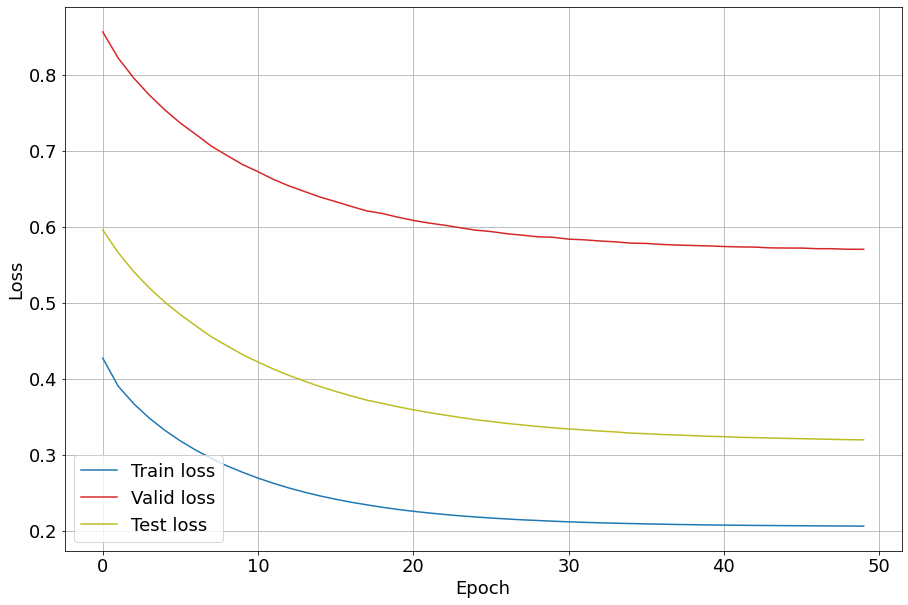

In [11]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss  = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        # output[y==0] = y[y==0]
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    # print(f"Train loss: {avg_loss}")
    return avg_loss

def valid_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss  = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            # output[y==0] = y[y==0]
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Valid loss: {avg_loss}")
    return avg_loss
    
def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss  = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            # output[y==0] = y[y==0]
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    '''
    CAVEAT: Model is put onto CPU in this function.
    '''
    output = torch.tensor([])
    
    model.cpu()
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

print("Untrained valid loss\n--------")
best_vl = valid_model(valid_loader, model, loss_function)
print(best_vl)
print()

train_loss = []
valid_loss = []
test_loss  = []
for ix_epoch in tqdm(range(PARAMS['n_epochs'])):
    tl = train_model(train_loader, model, loss_function, optimizer=optimizer)
    vl = valid_model(valid_loader, model, loss_function)
    train_loss.append(tl)
    valid_loss.append(vl)
    test_loss.append(test_model(test_loader, model, loss_function))
    if ix_epoch % (PARAMS['n_epochs'] // 4) == 0:
        print(f"Epoch {ix_epoch} / {PARAMS['n_epochs']}\n---------")
        print(f"Train loss: {tl}\nValid loss: {vl}\n")
    # Save model
    if vl < best_vl:
        torch.save(model.state_dict(), PATHS['lstm_path'])

# Plot
plt.plot(train_loss, label='Train loss', color='tab:blue')
plt.plot(valid_loss, label='Valid loss', color='tab:red')
plt.plot(test_loss,  label='Test loss',  color='tab:olive')
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.legend(loc='lower left');plt.grid()

# Load best model
model.load_state_dict(torch.load(PATHS['lstm_path']))

In [12]:
### METRICS
# Reshape
X_train_lrg = np.reshape(X_train, (-1, X_train.shape[1] * X_train.shape[2]))
y_train_lrg = np.reshape(y_train, (-1, y_train.shape[1] * y_train.shape[2]))
print('X_train regression:', X_train_lrg.shape, '\ny_train regression:', y_train_lrg.shape)
X_test_lrg  = np.reshape(X_test,  (-1, X_test.shape[1]  * X_test.shape[2]))
y_test_lrg  = np.reshape(y_test,  (-1, y_test.shape[1]  * y_test.shape[2]))

# Linear regression
lrg = linear_model.LinearRegression()
lrg.fit(X_train_lrg, y_train_lrg)
print('==> LINEAR \nR2: ', lrg.score(X_test_lrg, y_test_lrg))
print('RMSE Rmax (km):', round(du.rmse(du.inverse_scale_normalize(lrg.predict(X_test_lrg), MU, SIG, SCALE, 'usa_rmw'), du.inverse_scale_normalize(y_test_lrg, MU, SIG, SCALE, 'usa_rmw')), 2))

# # LASSO
# clf = linear_model.Lasso(alpha=1., tol=1)
# clf.fit(X_train_lrg, y_train_lrg)
# print('==> LASSO \nR2: ', lrg.score(X_test_lrg, y_test_lrg))
# print('RMSE Rmax (km):', round(du.rmse(du.inverse_scale_normalize(clf.predict(X_test_lrg), MU, SIG, SCALE, 'usa_rmw'), du.inverse_scale_normalize(y_test_lrg, MU, SIG, SCALE, 'usa_rmw')), 2))

# MODEL
test_dataset_cpu = pu.CompleteTimeseriesDataset(X_test, y_test)
test_loader_cpu  = DataLoader(test_dataset_cpu,  batch_size=PARAMS['batch_size'], shuffle=False)
preds            = predict(test_loader_cpu, model).cpu().detach().numpy()
print('\n==> MODEL')
print('RMSE Rmax (km):', round(du.rmse(du.inverse_scale_normalize(preds, MU, SIG, SCALE, 'usa_rmw'), du.inverse_scale_normalize(y_test_lrg, MU, SIG, SCALE, 'usa_rmw')), 2))

X_train regression: (69, 1440) 
y_train regression: (69, 360)
==> LINEAR 
R2:  -0.3969706362794219
RMSE Rmax (km): 46.07

==> MODEL
RMSE Rmax (km): 29.68


In [13]:
# X_im[0, 3, :]

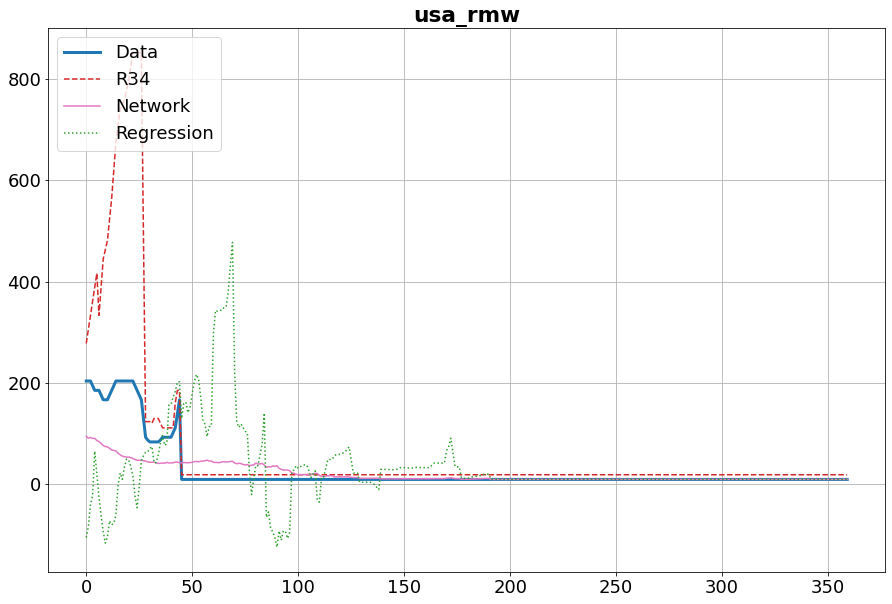

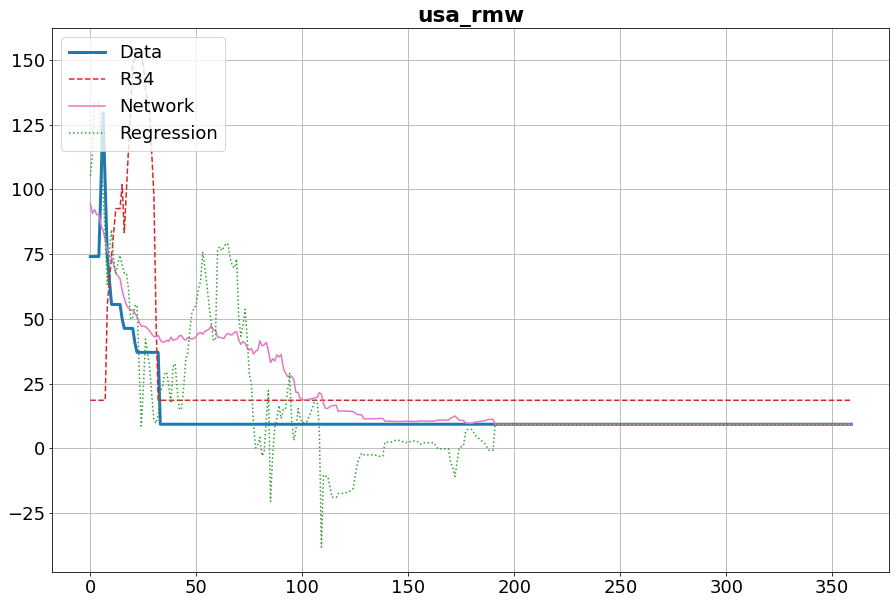

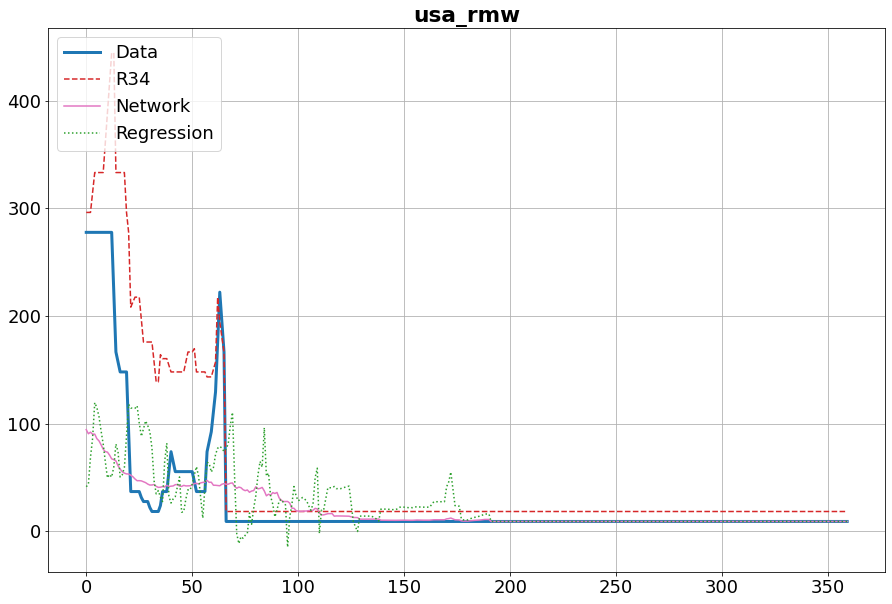

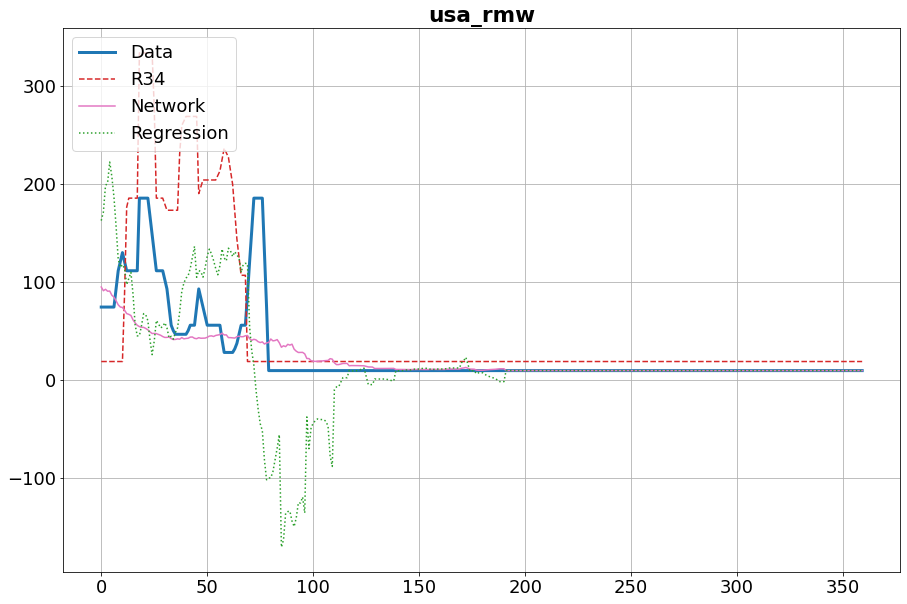

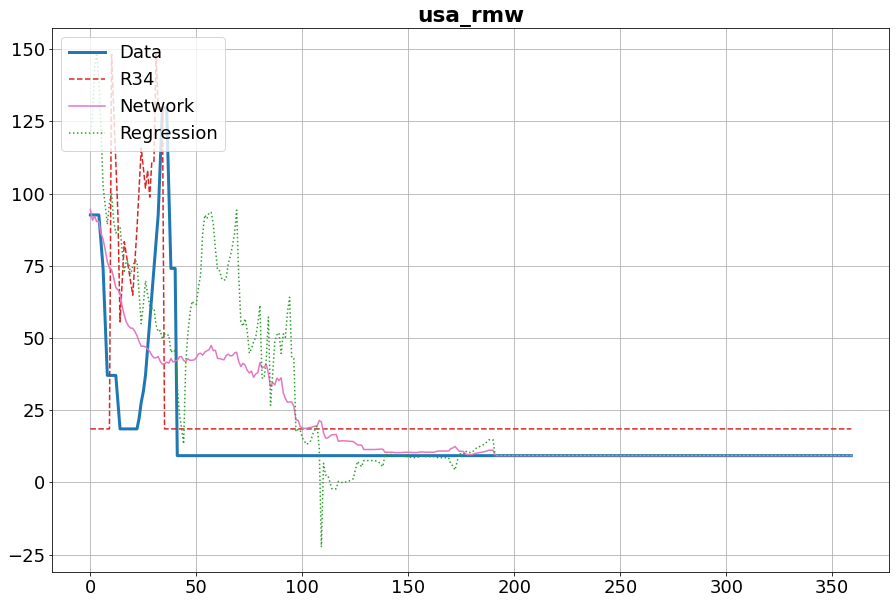

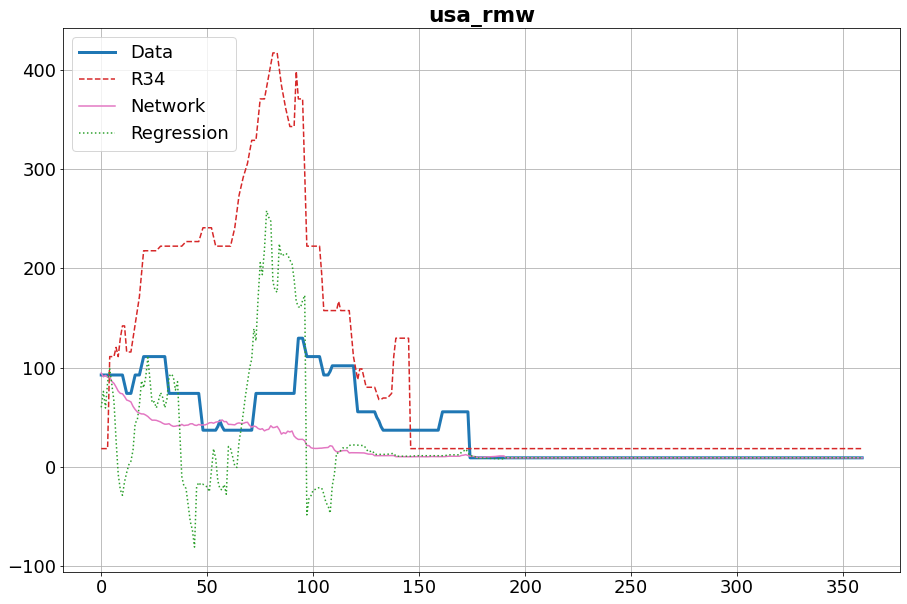

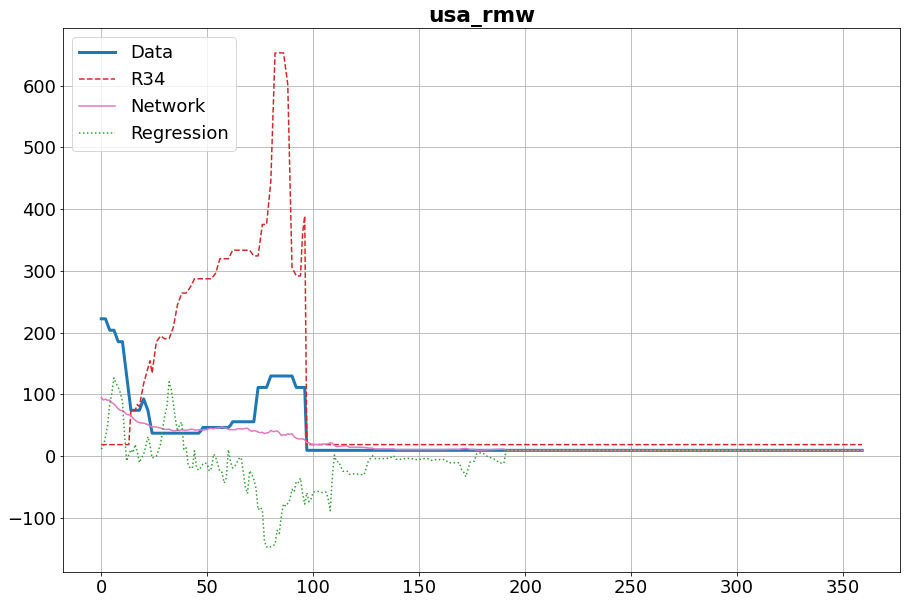

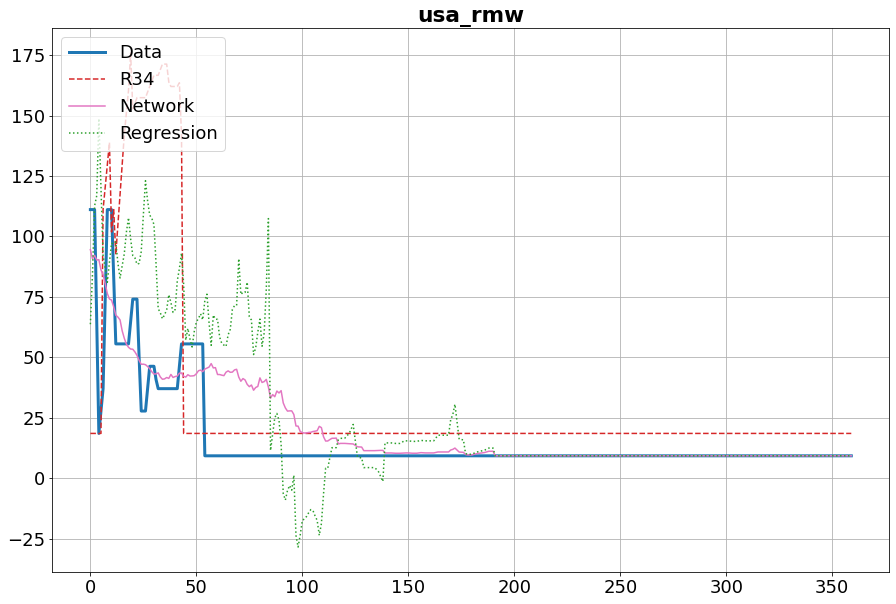

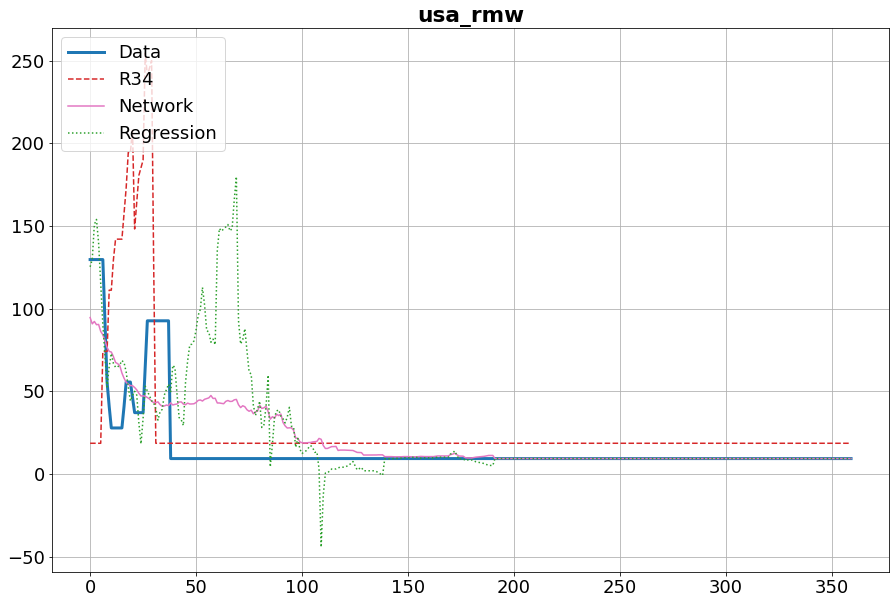

In [14]:
for s in range(6, 15):
    # Choose test sample
    ds_im        = ds_test.isel(storm=slice(s, s + 1))

    # Prepare inference data
    X_im, y_im   = du.get_X_and_y_arrays_from_Dataset(ds_im,  input_variables, target_variable)
    im_dataset   = pu.CompleteTimeseriesDataset(X_im, 
                                                y_im,
                                               )
    im_loader    = DataLoader(im_dataset,  batch_size=PARAMS['batch_size'], shuffle=False)
    # Inference
    y_pred       = predict(im_loader, model)
    # Target
    y_im         = np.array(y_im)

    # Plot
    # feature = .cpu().detach().numpy()
    feature = du.inverse_scale_normalize(y_pred, MU, SIG, SCALE, 'usa_rmw')
    target  = du.inverse_scale_normalize(y_im[0, 0, :],  MU, SIG, SCALE, 'usa_rmw')
    lin_fea = du.inverse_scale_normalize(lrg.predict(np.reshape(X_im, (-1, X_im.shape[1] * X_im.shape[2]))), MU, SIG, SCALE, 'usa_rmw')
    plt.title('usa_rmw', weight='bold')
    plt.plot(target,  label='Data', linewidth=3, color='tab:blue')
    plt.plot(du.inverse_scale_normalize(X_im[0, 3, :], MU, SIG, SCALE, 'usa_r34'), label='R34', color='tab:red', linestyle='--')
    plt.plot(feature[0, :], label='Network', color='tab:pink')
    plt.plot(lin_fea[0, :], label='Regression', color='tab:green', linestyle=':')
    plt.legend(loc='upper left');plt.grid()
    plt.show()

In [17]:
ds = ds_ibt.isel(storm=110)
ds

<xarray.Dataset>
Dimensions:     (date_time: 360)
Coordinates:
    time        (date_time) datetime64[ns] 2020-11-12T12:00:00.000039936 ... NaT
    lat         (date_time) float32 15.5 15.41 15.3 15.16 ... nan nan nan nan
    lon         (date_time) float32 -70.9 -71.42 -71.9 -72.33 ... nan nan nan
Dimensions without coordinates: date_time
Data variables:
    usa_lon     (date_time) float32 1.764 1.74 1.717 1.696 ... 0.0 0.0 0.0 0.0
    usa_lat     (date_time) float32 0.6777 0.6694 0.6591 0.6459 ... 0.0 0.0 0.0
    usa_wind    (date_time) float32 0.7228 0.7228 0.7228 0.7228 ... 0.0 0.0 0.0
    usa_r34     (date_time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    usa_rmw     (date_time) float32 2.648 2.648 2.648 2.648 ... 0.0 0.0 0.0 0.0
    numobs      float32 50.0
    sid         |S13 b'2020318N16289'
    basin       (date_time) |S2 b'NA' b'NA' b'NA' b'NA' ... b'' b'' b'' b''
    name        |S128 b'IOTA'
    usa_agency  (date_time) |S32 b'hurdat_atl' b'' b'hurdat_atl' ... b'' b'' b''
    iso_time    (date_time) |S19 b'2020-11-12 12:00:00' ... b''
    usa_status  (date_time) |S2 b'LO' b'LO' b'LO' b'LO' ... b'' b'' b'' b''

In [18]:
ds['usa_rmw'][:50]

<xarray.DataArray 'usa_rmw' (date_time: 50)>
array([2.6475883 , 2.6475883 , 2.6475883 , 2.6475883 , 2.6475883 ,
       2.6475883 , 2.6475883 , 2.6475883 , 2.6475883 , 2.6475883 ,
       2.6475883 , 2.6475883 , 2.6475883 , 2.4710822 , 2.2945762 ,
       2.0121667 , 1.7650586 , 1.4826492 , 1.2355411 , 1.1296376 ,
       1.0590352 , 0.7766259 , 0.5295176 , 0.5295176 , 0.5295176 ,
       0.5295176 , 0.5295176 , 0.42361405, 0.35301176, 0.24710819,
       0.17650588, 0.17650588, 0.17650588, 0.17650588, 0.17650588,
       0.24710819, 0.35301176, 0.35301176, 0.35301176, 0.5295176 ,
       0.60011995, 0.7060235 , 1.2355411 , 1.7650586 , 2.8946962 ,
       4.059635  , 4.412647  , 4.7656584 , 4.7656584 , 4.7656584 ],
      dtype=float32)
Coordinates:
    time     (date_time) datetime64[ns] 2020-11-12T12:00:00.000039936 ... 202...
    lat      (date_time) float32 15.5 15.41 15.3 15.16 ... 13.81 13.8 13.76 13.7
    lon      (date_time) float32 -70.9 -71.42 -71.9 ... -87.8 -88.39 -89.0
Dimensions without coordinates: date_time

In [19]:
ds['time'][:50]

<xarray.DataArray 'time' (date_time: 50)>
array(['2020-11-12T12:00:00.000039936', '2020-11-12T15:00:00.000039936',
       '2020-11-12T18:00:00.000039936', '2020-11-12T21:00:00.000039936',
       '2020-11-13T00:00:00.000039936', '2020-11-13T03:00:00.000039936',
       '2020-11-13T06:00:00.000039936', '2020-11-13T09:00:00.000039936',
       '2020-11-13T12:00:00.000039936', '2020-11-13T15:00:00.000039936',
       '2020-11-13T18:00:00.000039936', '2020-11-13T21:00:00.000039936',
       '2020-11-14T00:00:00.000039936', '2020-11-14T03:00:00.000039936',
       '2020-11-14T06:00:00.000039936', '2020-11-14T09:00:00.000039936',
       '2020-11-14T12:00:00.000039936', '2020-11-14T15:00:00.000039936',
       '2020-11-14T18:00:00.000039936', '2020-11-14T21:00:00.000039936',
       '2020-11-15T00:00:00.000039936', '2020-11-15T03:00:00.000039936',
       '2020-11-15T06:00:00.000039936', '2020-11-15T09:00:00.000039936',
       '2020-11-15T12:00:00.000039936', '2020-11-15T15:00:00.000039936',
       '2020-11-15T18:00:00.000039936', '2020-11-15T21:00:00.000039936',
       '2020-11-16T00:00:00.000039936', '2020-11-16T03:00:00.000039936',
       '2020-11-16T06:00:00.000039936', '2020-11-16T09:00:00.000039936',
       '2020-11-16T12:00:00.000039936', '2020-11-16T15:00:00.000039936',
       '2020-11-16T18:00:00.000039936', '2020-11-16T21:00:00.000039936',
       '2020-11-17T00:00:00.000039936', '2020-11-17T03:00:00.000039936',
       '2020-11-17T03:40:00.000058368', '2020-11-17T06:00:00.000039936',
       '2020-11-17T09:00:00.000039936', '2020-11-17T12:00:00.000039936',
       '2020-11-17T15:00:00.000039936', '2020-11-17T18:00:00.000039936',
       '2020-11-17T21:00:00.000039936', '2020-11-18T00:00:00.000039936',
       '2020-11-18T03:00:00.000039936', '2020-11-18T06:00:00.000039936',
       '2020-11-18T09:00:00.000039936', '2020-11-18T12:00:00.000039936'],
      dtype='datetime64[ns]')
Coordinates:
    time     (date_time) datetime64[ns] 2020-11-12T12:00:00.000039936 ... 202...
    lat      (date_time) float32 15.5 15.41 15.3 15.16 ... 13.81 13.8 13.76 13.7
    lon      (date_time) float32 -70.9 -71.42 -71.9 ... -87.8 -88.39 -89.0
Dimensions without coordinates: date_time
Attributes:
    long_name:              time
    standard_name:          time
    description:            Nominally, time steps are 3 hourly, but can be mo...
    Note:                   Variable:time can be missing since the tracks are...
    coverage_content_type:  physicalMeasurement

In [22]:
ds['usa_r34'][:50]

<xarray.DataArray 'usa_r34' (date_time: 50)>
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 2.9964178, 2.9964178,
       2.9964178, 2.9964178, 2.9964178, 2.9964178, 2.9964178, 2.9964178,
       2.9964178, 3.1034327, 2.461343 , 2.675373 , 2.8894026, 3.1569405,
       3.424477 , 3.7990298, 4.173582 , 4.5481343, 4.9226866, 5.2437305,
       5.564776 , 5.8323135, 6.0998507, 6.0998507, 6.0998507, 6.0998507,
       6.0998507, 6.0035377, 5.9928355, 5.7788057, 5.2972383, 4.8156714,
       5.2794027, 4.7086563, 5.564776 , 5.350746 , 5.564776 , 5.564776 ,
       0.       , 0.       ], dtype=float32)
Coordinates:
    time     (date_time) datetime64[ns] 2020-11-12T12:00:00.000039936 ... 202...
    lat      (date_time) float32 15.5 15.41 15.3 15.16 ... 13.81 13.8 13.76 13.7
    lon      (date_time) float32 -70.9 -71.42 -71.9 ... -87.8 -88.39 -89.0
Dimensions without coordinates: date_time

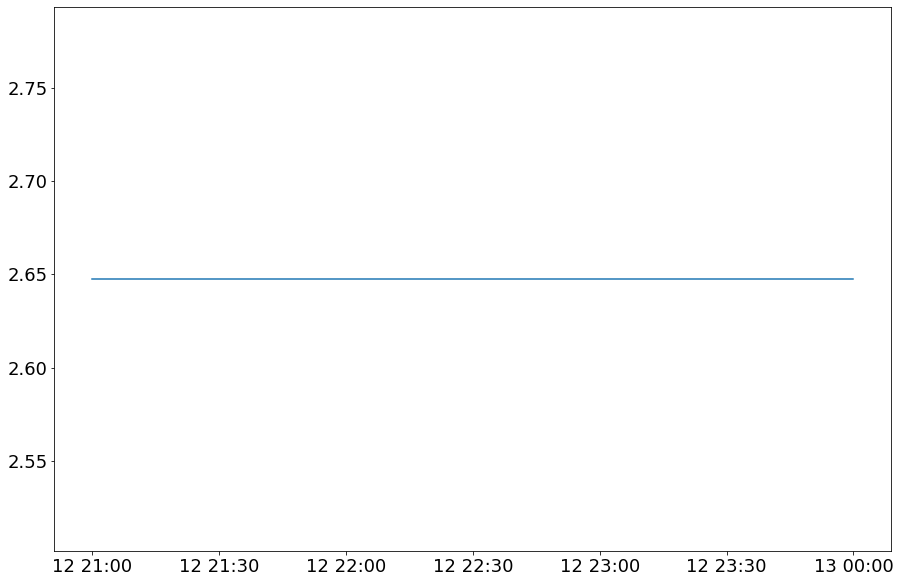

In [21]:
plt.plot(ds['time'][3:5], ds['usa_rmw'][3:5])

In [ ]:
plt.plot(ds['time'][13:15], ds['usa_r34'].mean(dim='quadrant', skipna=True)[13:15])
plt.grid()